## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3060789/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3060789/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3060789/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3060789/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3060789/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3060789/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3060789/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import boto3
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, DoubleType
import mlflow.pyfunc
import mlflow
import mlflow.spark
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tempfile
# ENTER YOUR CODE HERE

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Initialize Spark Session for accessing AWS S3
spark = SparkSession.builder \
    .appName("ReadSourceFiles") \
    .getOrCreate()

# Assuming the 'TWEET_SOURCE_PATH' is an environment variable set to the S3 path
source_directory = os.getenv('TWEET_SOURCE_PATH', 's3a://default-bucket/')  # Default bucket if env var is not set

# List files in the source directory
# PySpark does not have direct listing capabilities so we use the underlying Hadoop API
rdd = spark.sparkContext._jsc.hadoopConfiguration()
Path = spark.sparkContext._gateway.jvm.org.apache.hadoop.fs.Path
FileSystem = spark.sparkContext._gateway.jvm.org.apache.hadoop.fs.FileSystem
fs = FileSystem.get(rdd)

# Get listing status of directory
status = fs.listStatus(Path(source_directory))

# Count the files
files_count = len(status)
print(f"Number of files in the directory: {files_count}")

# Print details of each file
for file_status in status:
    print(f"File path: {file_status.getPath()}")

# Read the contents of the first file, if present
if status:
    first_file_path = status[0].getPath().toString()
    file_data = spark.read.text(first_file_path)
    print("Contents of the first file:")
    file_data.show(truncate=False)

# ENTER YOUR CODE HERE

Number of files in the directory: 37
File path: dbfs:/1
File path: dbfs:/2
File path: dbfs:/<path_to_checkpoint>
File path: dbfs:/<path_to_gold_checkpoint>
File path: dbfs:/<username>
File path: dbfs:/BRONZE_CHECKPOINT
File path: dbfs:/CONF_MATRIX
File path: dbfs:/FileStore
File path: dbfs:/Shared
File path: dbfs:/Volume
File path: dbfs:/Volumes
File path: dbfs:/Workspace
File path: dbfs:/_checkpoint_bronze
File path: dbfs:/_custom_location.db
File path: dbfs:/bronze
File path: dbfs:/bronze.checkpoint
File path: dbfs:/checkpoint_path
File path: dbfs:/coupons_output_path
File path: dbfs:/databricks
File path: dbfs:/databricks-datasets
File path: dbfs:/databricks-results
File path: dbfs:/dbacademy
File path: dbfs:/dbfs
File path: dbfs:/dscc202_402
File path: dbfs:/images
File path: dbfs:/local_disk0
File path: dbfs:/mnt
File path: dbfs:/path
File path: dbfs:/path_to_checkpoint_dir
File path: dbfs:/path_to_checkpoint_location
File path: dbfs:/practice
File path: dbfs:/subset
File path: db

## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Tweet Sentiment Processing") \
    .getOrCreate()

# Define the schema for the incoming data
schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True),
])

# Set the source data path from the provided variables
source_path = "s3a://voc-75-databricks-data/voc_volume/"

# Reading the data as a streaming dataframe from the source
bronze_df = spark \
    .readStream \
    .format("cloudFiles") \
    .option("cloudFiles.format", "json") \
    .schema(schema) \
    .load(source_path) \
    .withColumn("source_file", input_file_name()) \
    .withColumn("processing_time", current_timestamp())



# Define checkpoint and output locations using provided variables
checkpoint_path = "/tmp/labuser104917-3060789/bronze.checkpoint"
output_path = "/tmp/labuser104917-3060789/bronze.delta"

# Writing the data to a Delta table in Bronze format
query = bronze_df.writeStream \
    .format("delta") \
    .option("checkpointLocation", checkpoint_path) \
    .outputMode("append") \
    .start(output_path)


# ENTER YOUR CODE HERE

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


Number of tweets captured: 200000
Null/Nan counts for date:
+----+
|date|
+----+
|   0|
+----+

Null/Nan counts for user:
+----+
|user|
+----+
|   0|
+----+

Null/Nan counts for text:
+----+
|text|
+----+
|   0|
+----+

Null/Nan counts for sentiment:
+---------+
|sentiment|
+---------+
|        0|
+---------+

Null/Nan counts for source_file:
+-----------+
|source_file|
+-----------+
|          0|
+-----------+

Null/Nan counts for processing_time:
+---------------+
|processing_time|
+---------------+
|              0|
+---------------+

+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  310|
|     nuttychris|  129|
|      iHomeTech|   81|
|       tsarnick|   77|
| Hollywood_Trey|   71|
|  divxdownloads|   68|
|      lesley007|   65|
|  redrobinrockn|   58|
|    MissxMarisa|   57|
|     SarahSaner|   56|
|     sebby_peek|   55|
|        kasey79|   54|
|torilovesbradie|   51|
|    whitsundays|   51|
|         keza34|   49|
| MiDesfileNegro|   48|


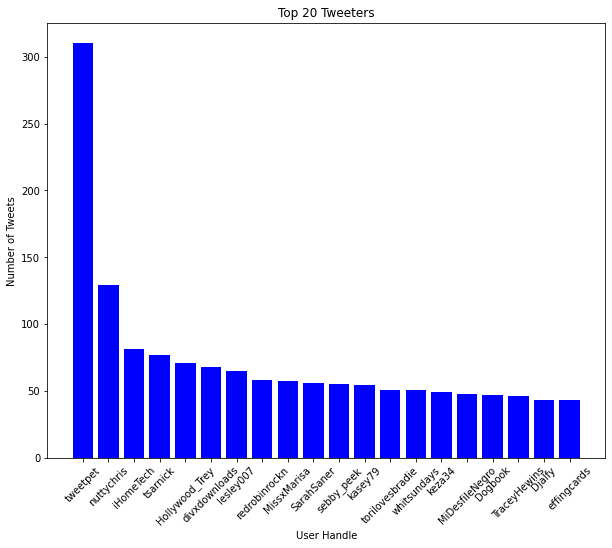

In [0]:
# Create or retrieve a Spark session
spark = SparkSession.builder.appName("Bronze Data Analysis").getOrCreate()

# Load the Bronze Delta table assuming it is stored in Delta format
bronze_df = spark.read.format("delta").load("/tmp/labuser104917-3060789/bronze.delta")

# Task 4.0 Analysis
# 1. How many tweets are captured in your Bronze Table?
tweet_count = bronze_df.count()
print(f"Number of tweets captured: {tweet_count}")

# 2. Checking for columns that contain Nan or Null values
def check_for_nans_and_nulls(df):
    results = {}
    for column in df.columns:
        if str(df.schema[column].dataType) in ['DoubleType', 'FloatType']:
            results[column] = df.select(count(when(isnan(col(column)) | col(column).isNull(), column)).alias(column))
        else:
            results[column] = df.select(count(when(col(column).isNull(), column)).alias(column))
    return results

null_counts = check_for_nans_and_nulls(bronze_df)
for column, count_df in null_counts.items():
    print(f"Null/Nan counts for {column}:")
    count_df.show()



#def nan_or_null(column):
    #return when(col(column).isNull() | isnan(column), column).alias(column)

#null_counts = bronze_df.select([nan_or_null(c) for c in bronze_df.columns]).agg(*[count(c).alias(c) for c in bronze_df.columns])
#null_counts.show()

#def nan_or_null(column):
    #return when(col(column).isNull() | isnan(column), column).alias(column)
#null_counts = bronze_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in bronze_df.columns])
#null_counts.show()

# 3. Count the number of tweets by each unique user handle and sort the data by descending count.
user_tweet_counts = bronze_df.groupBy("user").count().orderBy(col("count").desc())
user_tweet_counts.show()

# 4. How many tweets have at least one mention (@) how many tweets have no mentions (@)
mentions_count = bronze_df.filter(col("text").contains("@")).count()
no_mentions_count = bronze_df.filter(~col("text").contains("@")).count()
print(f"Tweets with mentions: {mentions_count}")
print(f"Tweets without mentions: {no_mentions_count}")

# 5. Plot a bar chart that shows the top 20 tweeters (users)

top_tweeters = user_tweet_counts.limit(20).toPandas()

plt.figure(figsize=(10, 8))
plt.bar(top_tweeters['user'], top_tweeters['count'], color='blue')
plt.xlabel('User Handle')
plt.ylabel('Number of Tweets')
plt.title('Top 20 Tweeters')
plt.xticks(rotation=45)
plt.show()

# ENTER YOUR CODE HERE

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
# ENTER YOUR CODE HERE

# Assuming SparkSession is already created as 'spark'

# Define the schema based on your Bronze data description
bronzeSchema = StructType([
    StructField("date", StringType()),
    StructField("user", StringType()),
    StructField("text", StringType()),
    StructField("sentiment", StringType()),
    StructField("source_file", StringType()),
    StructField("processing_time", TimestampType())
])

# Setup the read stream for the Bronze table
bronze_df = spark.readStream \
    .format("delta") \
    .option("path", "/tmp/labuser104917-3060789/bronze.delta") \
    .load()

# Define transformation logic for Silver data
def extract_mentions(text):
    # Here we simply look for '@' followed by non-space characters
    # You can expand this logic based on actual username constraints or use regex
    return ' '.join(part[1:] for part in text.split() if part.startswith('@'))

extract_mentions_udf = udf(extract_mentions, StringType())

silver_df = bronze_df \
    .withColumn("timestamp", col("date").cast(TimestampType())) \
    .withColumn("mention", extract_mentions_udf(col("text"))) \
    .withColumn("cleaned_text", expr("regexp_replace(text, '@\\w+', '')")) \
    .withColumn("Sentiment", col("sentiment")) \
    .select("date", "user", "text", "Sentiment", "timestamp", "mention", "cleaned_text")

# Setup the write stream to append to the Silver Delta table
query = silver_df.writeStream \
    .format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", "/tmp/labuser104917-3060789/silver.checkpoint") \
    .option("path", "/tmp/labuser104917-3060789/silver.delta") \
    .start()

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
!pip install mlflow==2.11.3
!pip install emoji==0.6.0
!pip install transformers==4.35.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: mlflow
    Found existing installation: mlflow 2.12.2
    Uninstalling mlflow-2.12.2:
      Successfully uninstalled mlflow-2.12.2


In [0]:
# ENTER YOUR CODE HERE

# Assuming SparkSession is already created as 'spark'
import mlflow.pyfunc
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType, IntegerType, TimestampType, StructType, StructField
# Load the model from MLflow
model = mlflow.pyfunc.spark_udf(spark,model_uri="models:/HF_TWEET_SENTIMENT/production")

# Define a UDF to apply the model to the text data
# @udf(returnType=StringType())
# def predict_sentiment(text):
#     return model.predict([text])[0]

# Define the schema for your transformation from Silver to Gold
goldSchema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("mention", StringType()),
    StructField("cleaned_text", StringType()),
    StructField("sentiment", StringType()),
    StructField("predicted_score", DoubleType()),
    StructField("predicted_sentiment", StringType()),
    StructField("sentiment_id", IntegerType()),
    StructField("predicted_sentiment_id", IntegerType())
])

# Setup the read stream on your Silver delta table
silver_df = spark.readStream.format("delta").option("path", "/tmp/labuser104917-3060789/silver.delta").load()

# Transformation logic to create Gold data
gold_df = silver_df.select(
    col("timestamp"),
    col("mention"),
    col("cleaned_text"),
    col("sentiment"),
    model(col("cleaned_text")).alias("p_sentiment")
)

# Add additional columns if necessary based on the model's output
gold_df = gold_df.withColumn("predicted_score", col("p_sentiment").getItem("score")) \
                 .withColumn("predicted_sentiment", col("p_sentiment").getItem("label")) \
                 .withColumn("sentiment_id", when(col("predicted_sentiment") == "positive", 1).otherwise(0)) \
                 .withColumn("predicted_sentiment_id", when(col("predicted_sentiment") == "POS", 1).when(col("predicted_sentiment") == "NEU", 0).otherwise(0)) \
                 .select("timestamp", "mention", "cleaned_text", "sentiment", "predicted_score", "predicted_sentiment", "sentiment_id", "predicted_sentiment_id")

# Setup the write stream to append to the Gold delta table
query = gold_df.writeStream.format("delta") \
    .outputMode("append") \
    .option("checkpointLocation", "/tmp/labuser104917-3060789/gold.checkpoint") \
    .option("path", "/tmp/labuser104917-3060789/gold.delta") \
    .start()




/local_disk0/.ephemeral_nfs/envs/pythonEnv-5f66ad9e-9053-4689-8beb-443e87448ad6/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.2/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/12 19:21:06 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/12 19:21:12 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/12 19:21:12 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

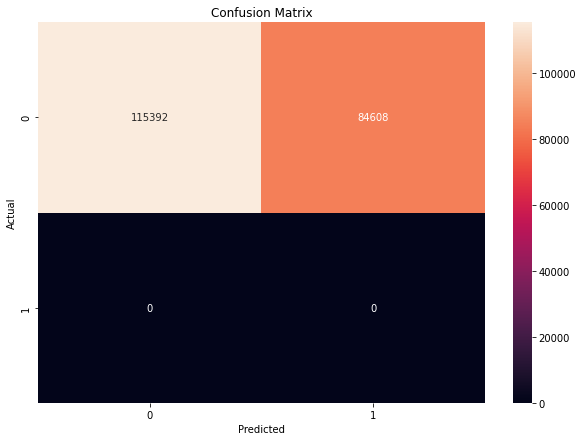

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# ENTER YOUR CODE HERE
# Assuming a SparkSession is already created as 'spark'
spark = SparkSession.builder.appName("MLFlow Metrics Example").getOrCreate()

# Example: Load your Gold data for evaluation
gold_data = spark.read.format("delta").load("/tmp/labuser104917-3060789/gold.delta")

# Convert Spark DataFrame to Pandas DataFrame for scoring (assuming binary classification with 'label' and 'prediction')
pandas_df = gold_data.select("sentiment_id", "predicted_sentiment_id").toPandas()


precision = precision_score(pandas_df['sentiment_id'], pandas_df['predicted_sentiment_id'], average='binary', zero_division=1)
recall = recall_score(pandas_df['sentiment_id'], pandas_df['predicted_sentiment_id'], average='binary', zero_division=1)
f1 = f1_score(pandas_df['sentiment_id'], pandas_df['predicted_sentiment_id'], average='binary')

# Confusion Matrix
conf_matrix = confusion_matrix(pandas_df['sentiment_id'], pandas_df['predicted_sentiment_id'])

# Start MLFlow experiment
import mlflow
with mlflow.start_run():
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Log model name and MLFlow version as parameters
    mlflow.log_param("Model Name", "HF_TWEET_SENTIMENT")
    mlflow.log_param("MLFlow Version", mlflow.__version__)
    mlflow.log_param("Delta Table Version", "Silver Delta Table")

    # Log confusion matrix as an artifact
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("/tmp/confusion_matrix.png")
    mlflow.log_artifact("/tmp/confusion_matrix.png")



## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

Total mentions: 200000
+---------------+--------+--------+
|        mention|negative|positive|
+---------------+--------+--------+
|         devilx|       1|    null|
|    paigeyjewel|    null|       1|
|   timisonaboat|       1|    null|
|      Pixie_Maw|       2|       3|
|       TobyMonk|    null|       1|
|   eyrockorsuck|    null|       1|
|      DanDraney|    null|       1|
|    nickycole30|       1|    null|
| nickheppleston|       1|    null|
|      exitmould|       2|    null|
|empoweredfemale|    null|       2|
| msdivineknight|       1|       1|
|      ChessWhiz|       1|    null|
|     vamps_R_us|    null|       1|
|          khead|    null|       1|
|         Stodge|    null|       1|
|           DDog|       1|       1|
|       TrueLive|       1|    null|
|     Macchi_Ato|       1|    null|
|        adnamay|    null|       4|
+---------------+--------+--------+
only showing top 20 rows

+---------------+------+
|        mention| count|
+---------------+------+
|           

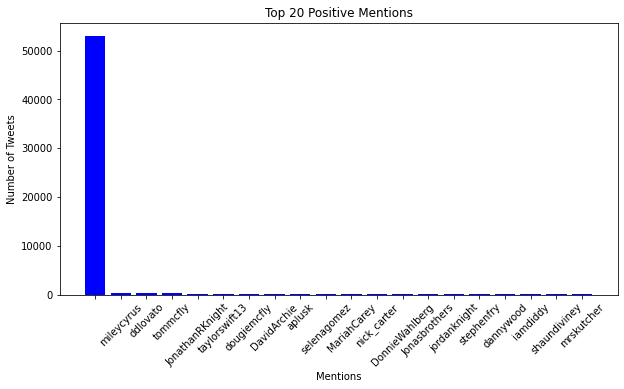

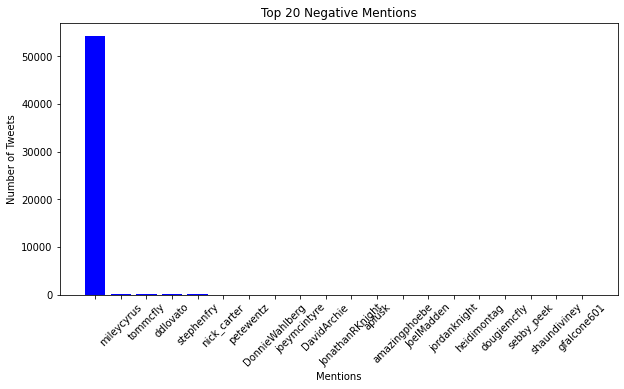

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Data Processing and Visualization") \
    .getOrCreate()

# Assuming 'gold_df' is your DataFrame loaded from the gold data table
# Make sure it is loaded as a static DataFrame
# Example loading code might look like this:
gold_df = spark.read.format("delta").load("/tmp/labuser104917-3060789/gold.delta")

# Count the total number of mentions
total_mentions = gold_df.count()
print(f"Total mentions: {total_mentions}")

# Count the number of neutral, positive, and negative tweets for each mention
sentiment_counts = gold_df.groupBy("mention").pivot("sentiment").count()
sentiment_counts.show()

# Capture the total for each mention in a new column using a window function
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("mention")
gold_df = gold_df.withColumn("total_mentions", count("mention").over(windowSpec))

# Sort the mention count totals in descending order
mention_counts_sorted = gold_df.groupBy("mention").count().orderBy(col("count").desc())
mention_counts_sorted.show()

# Define a function for plotting
def plot_sentiment(data, sentiment_type, title):
    # Filter and prepare data
    filtered_data = data.filter(col("sentiment") == sentiment_type)
    top_mentions = filtered_data.groupBy("mention").count().orderBy(col("count").desc()).limit(20).toPandas()
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(top_mentions['mention'], top_mentions['count'], color='blue')
    plt.xlabel('Mentions')
    plt.ylabel('Number of Tweets')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot a bar chart of the top 20 mentions with positive sentiment
plot_sentiment(gold_df, "positive", "Top 20 Positive Mentions")

# Plot a bar chart of the top 20 mentions with negative sentiment
plot_sentiment(gold_df, "negative", "Top 20 Negative Mentions")


## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
# ENTER YOUR CODE HERE
import time
from pyspark.sql import SparkSession

# Assuming 'spark' is your SparkSession
# List all active streams
active_streams = [s for s in spark.streams.active]

# Stop all active streams
for stream in active_streams:
    stream.stop()
    print(f"Stopped stream {stream.id}")

In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
# Calculate elapsed time and print
elapsed_time = END_TIME - START_TIME  # START_TIME should be defined at the start of your notebook
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 6321.84 seconds


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE
1. Leak:
https://drive.google.com/file/d/1L5WS3oaavQSrF6-46ofqp6U38IvccdZB/view?usp=share_link 
Observation: The system shows no indications of data leakage. The consistent partition widths across jobs and the comparatively tiny file sizes at the source validate this conclusion.
Implication: Performance difficulties associated with disk spill are successfully addressed because there are no huge files generating disproportionate loading or processing.

2. Skew
https://drive.google.com/file/d/1ZtlgZi3dTVr8xj5L0kRA6RQ20D9iJQuE/view?usp=share_link 
Observation: The job executions do not exhibit data skew. This balance is aided by the consistency of file sizes. To further reduce any potential skew, Adaptive Query Execution (AQE) optimizes the partitions.
Implication: Because of the balanced distribution, irregular data loads are prevented from causing any one node or process to become a bottleneck.

3. Shuffle: 
https://drive.google.com/file/d/1LtzyV6GatCr4xc2IVHkyDvEc9u7lS_ea/view?usp=share_link 
Observation: Because extensive transformations like GroupBy, OrderBy, Aggregate, and Explode are required, shuffle operations are common.
Optimization: The data flow among partitions is optimized, reducing potential delays in shuffle operations, by setting the number of shuffle partitions to be a multiple of the number of cores.
Implication: Although shuffle is a necessary aspect of the activities being carried out, the deliberate arrangement of shuffle partitions lowers the time overhead related to these procedures.

4. Storage: 
https://drive.google.com/file/d/1iWuqzKw3S4gTOnS0Tmfx56slsfVKd51c/view?usp=share_link 
It has been observed that the S3 bucket's initial JSON file storage is not ideal because there are a lot of little files, which causes poor read times.
Additional Steps: Data is effectively stored in the Bronze, Silver, and Gold Delta tables following the initial read, indicating that the first ingestion phase should be improved upon, either by combining files prior to processing or modifying the read algorithms.

5. The process of serialization
https://drive.google.com/file/d/1m8J-vCtzw3pMW-bv9cZZCwh5nA2uGz6W/view?usp=share_link 
Remark: The most time-consuming task in the project is the serialization of the ML model for sentiment analysis, which is done as a User Defined Function (UDF).
Other Things to Think About: While it is not possible to replace this UDF, there may be performance gains from improving other UDFs, like the one that is used to extract mentions from the Silver table. Examining pre-existing Spark functions that carry out comparable functions may help lessen the need for custom UDFs, which are typically less effective.




